# 0.0. IMPORTS

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns

import math
import inflection
import datetime

from matplotlib import pyplot as plt

from IPython.core.display import HTML
from IPython.display      import Image

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)

In [3]:
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

In [4]:
# Merge Datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
# Plot random line only to check
#df_raw.sample()

# 1.0. DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Columns Descriptions

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince\[Month\/Year\]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since\[Year\/Week\]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.2. Rename Columns 

In [7]:
# Nome das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
            'Promo2SinceYear', 'PromoInterval']

In [8]:
# Função que irá alterar o nome das colunas para o padrão snake_case
snakecase = lambda x: inflection.underscore(x)

In [9]:
# Aplicação da função anterior.
# Utilizamos a função *map* para aplicarmos a função *snakecase* em todos 
# os itens da lista *cols_old*. O resultado disso deverá ser transformado
# em uma lista
cols_new = list(map(snakecase, cols_old))

In [10]:
# Renomeia as colunas do DF
df1.columns = cols_new

## 1.3. Data Dimension 

In [11]:
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Columns: {df1.shape[1]}")

Number of Rows: 1017209
Number of Columns: 18


## 1.4. Data Types 

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
df1['date'] = pd.to_datetime(df1['date'])

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.5. Check NA 

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.6. Fillout NA

### 1.5.1. competition_distance

In [16]:
df1['competition_distance'].max()

75860.0

In [17]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 2000000 if math.isnan(x) else x)

### 1.5.2. competition_open_since_month

In [18]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(
    x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

### 1.5.3. competition_open_since_year

In [19]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

### 1.5.4. promo2_since_week

In [20]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(
    x['promo2_since_week']) else x['promo2_since_week'], axis=1)

### 1.5.5. promo2_since_year

In [21]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['promo2_since_year']) else x['promo2_since_year'], axis=1)

### 1.5.6. promo_interval

In [22]:
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'}

In [23]:
df1['promo_interval'].fillna(0, inplace=True)

In [24]:
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [25]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else
              1 if x['month_map'] in x['promo_interval'].split(',') else 0,
    axis=1)

### 1.5.7. Checking NA

In [26]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.7. Change Types

In [27]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [28]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [29]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.8. Descriptive Statistical

### 1.8.1. Categorical and Numeric Separation

In [30]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.8.2. Numerical Attributes

#### 1.8.2.1. Central Tendency

In [31]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#### 1.8.2.2. Dispersion Tendency

In [32]:
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#### 1.8.2.3. Dispersions Concatenation 

In [33]:
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d6, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,375.644405,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,124.071304


### 1.8.3. Numerical Attributes

In [34]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

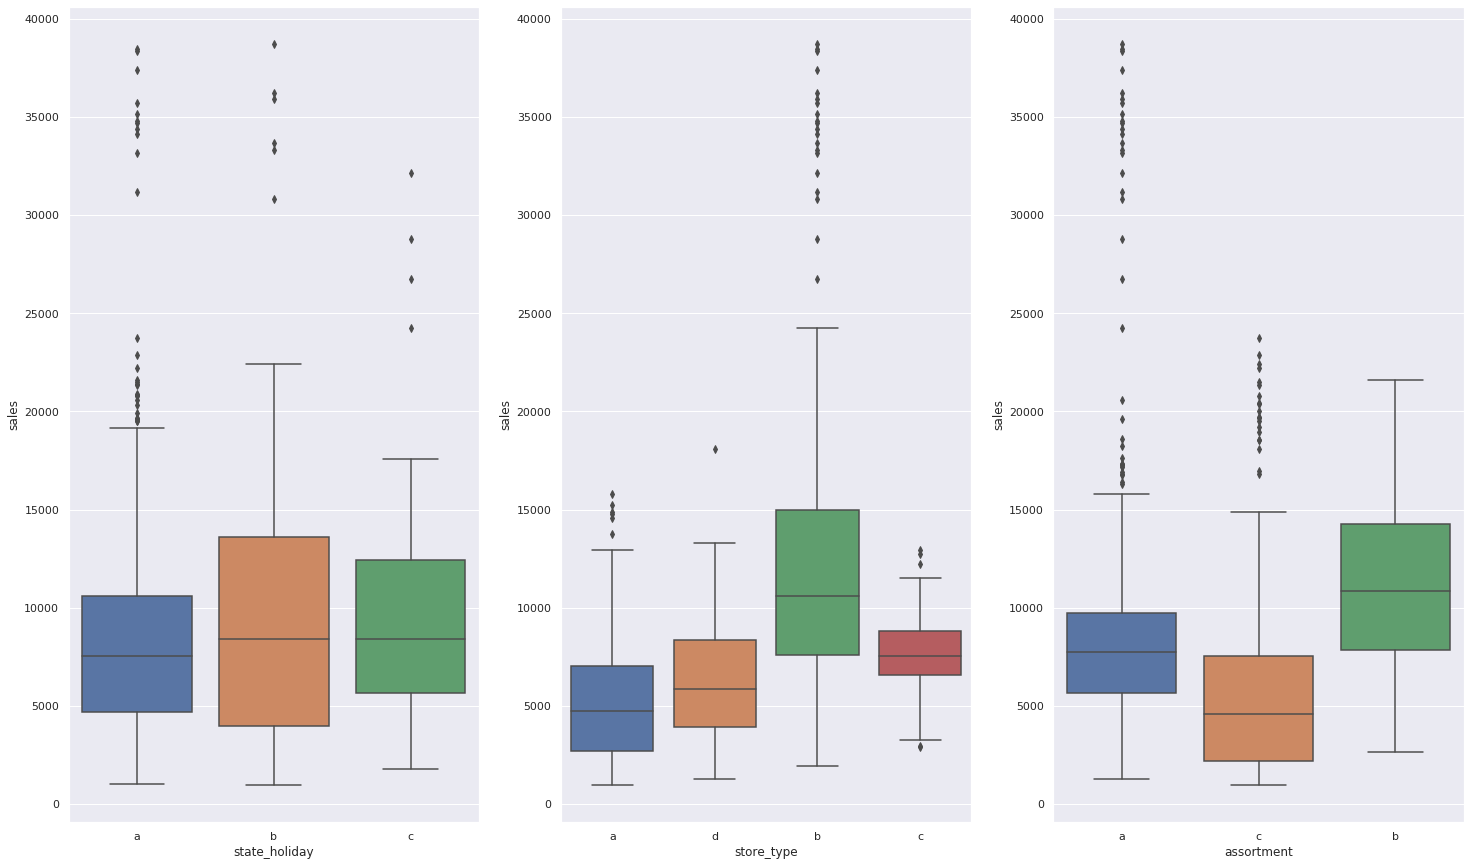

In [35]:
aux1 = df1[ (df1['sales'] > 0) & (df1['state_holiday'] != '0') ]

sns.set(rc = {'figure.figsize':(25, 15)})

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. FEATURE ENGINEERING

In [36]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

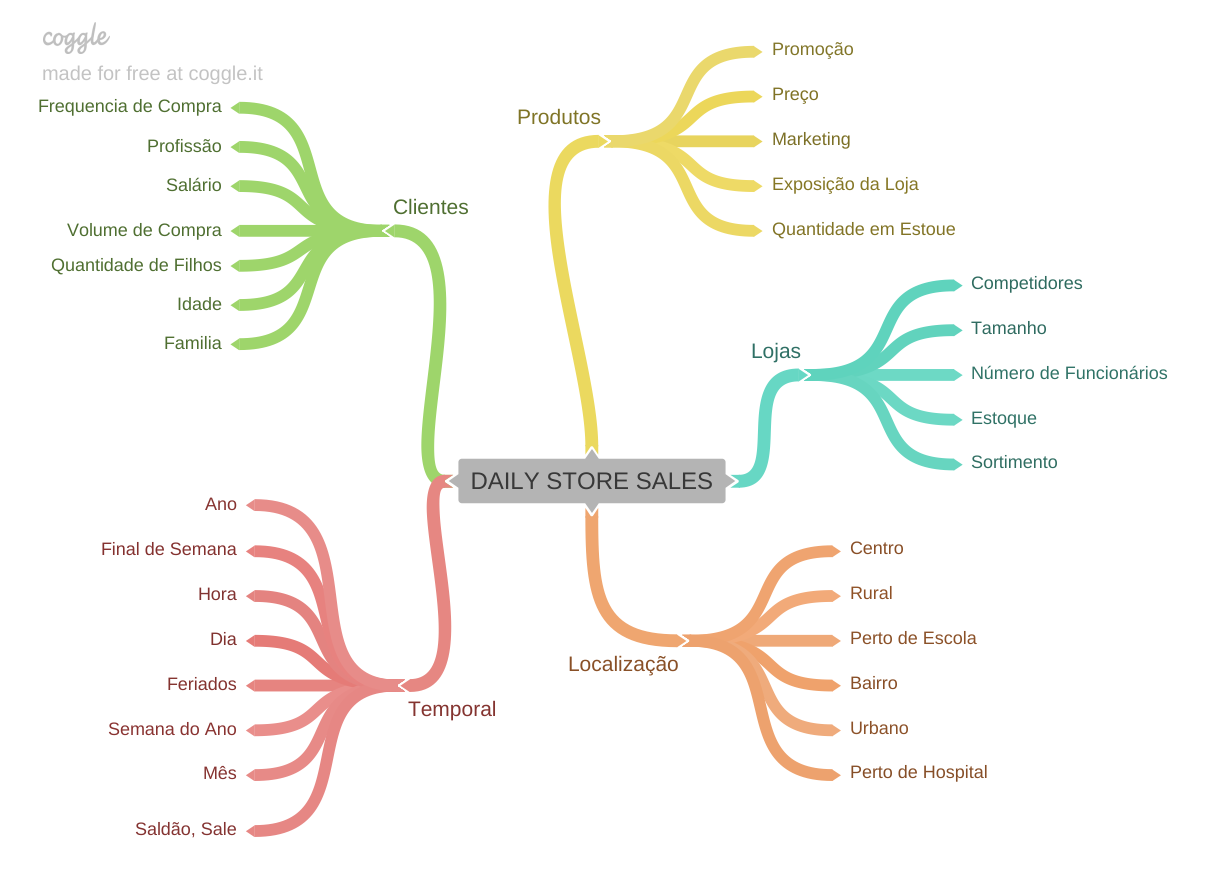

In [37]:
Image('images/mind_map_hypothesis.png')

## 2.2. Hypotesis

### 2.2.1. Store Hypotesis

**1.** Lojas com Maior Número de funcionários deveriam vender mais

**Não possuímos a quantidade de funcionários no Dataset**

**2.** Lojas com maior capacidade de estoque maior deveriam vender mais

**Não possuímos o tamanho do estoque no Dataset**

**3.** Lojas com maior porte deveriam vender mais

**Não possuímos o porte da loja no Dataset**

**4.** Lojas com maior sortimento de produtos vender mais

**Possuímos o tipo de sortimento das lojas, separadas por categorias. Coluna _Assortment_**

**5.** Lojas com competidores mais próximos deveriam vender menos

**Possuímos a distancia das lojas e seus competidores mais próximos. Coluna _CompetitionDistance_**

**6.** Lojas com competidores à mais tempo deveriam vender mais

**Possuímos o tempo decorrido da abertura dos competidores perto das lojas. Colunas _CompetitionOpenSince\[Month\/Year\]_**

### 2.2.2. Product Hypotesis

**1.** Lojas que investem mais em marketing deveriam vender mais

**Não possuímos o budget de investimento em marketing das lojas no Dataset**

**2.** Lojas com maior exposição dos produtos deveriam vender mais


**Não possuímos a quantidade de produtos expostas nas lojas no Dataset**

**3.** Lojas com produtos com preços menores deveriam vender mais

**Não possuímos o preço dos produtos das lojas no Dataset**

**4.** Lojas com descontos mais agressios (preços menores) deveriam vender mais

**Não possuímos o valor do descont das lojas no Dataset**

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**Possuímos colunas para verificar o tempo decorrido que uma loja esteve em promoção. Colunas _Promo2_ , _Promo2Since\[Year\/Week\]_ , _PromoInterval_**

**6.** Lojas com mais dias em promoção deveriam vender mais

**Possuímos colunas para verificar o tempo decorrido que uma loja esteve em promoção. Colunas _Promo2_ , _Promo2Since\[Year\/Week\]_ , _PromoInterval_**

**7.** Lojas com mais promoções consecutivas deveriam vender mais

**Possuímos colunas para verificar o tempo decorrido que uma loja esteve em promoção. Colunas _Promo2_ , _Promo2Since\[Year\/Week\]_ , _PromoInterval_**

### 2.2.3. Temporal Hypotesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**Possuímos colunas para verificar se as lojas estiveram abertas em feriados e em quais feriados. Colunas _Open_ , _StateHoliday_**

**2.** Lojas deveriam vender mais ao longo dos anos

**Possuímos uma coluna que pode ser derivada e criada uma nova coluna para validarmos essa hipótese. Coluna _date_**

**3.** Lojas deveriam vender mais no segundo semestre do ano

**Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna _date_**

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna _date_**

**5.** Lojas deveriam vender menos aos finais de semana

**Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna _date_**

**6.** Lojas deveriam vender menos durante os feriados escolares

**Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna _date_**

## 2.3. Chosen Hypotesis

**1.** Lojas com maior sortimento de produtos vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender mais

**4.** Lojas com prmnoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias em promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.4. Feature Engineering

In [38]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. FILTERING FEATURES

In [40]:
df3 = df2.copy()

## 3.1. Filtering Lines

In [41]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [48]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] 

In [49]:
df3.drop(cols_drop, axis=1, inplace=True)